2025-08-17 13:53:42.118075: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-17 13:53:42.147304: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-17 13:53:42.331189: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-17 13:53:42.332805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-17 13:53:43.358328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

[Contrastive] Epoch 1/10, loss=0.5519
[Contrastive] Epoch 2/10, loss=1.2857
[Contrastive] Epoch 3/10, loss=0.4218
[Contrastive] Epoch 4/10, loss=0.3695
[Contrastive] Epoch 5/10, loss=0.1637
[Contrastive] Epoch 6/10, loss=0.6623
[Contrastive] Epoch 7/10, loss=0.7582
[Contrastive] Epoch 8/10, loss=0.6426
[Contrastive] Epoch 9/10, loss=0.1865
[Contrastive] Epoch 10/10, loss=0.2310
[Meta] Epoch 1/20, query_loss=1.2712, query_acc=0.0000
[Meta] Epoch 2/20, query_loss=1.2125, query_acc=0.0000
[Meta] Epoch 3/20, query_loss=1.1264, query_acc=0.0000
[Meta] Epoch 4/20, query_loss=1.0530, query_acc=0.0000
[Meta] Epoch 5/20, query_loss=0.9725, query_acc=0.1000
[Meta] Epoch 6/20, query_loss=0.8942, query_acc=0.9700
[Meta] Epoch 7/20, query_loss=0.8492, query_acc=0.9800
[Meta] Epoch 8/20, query_loss=0.7759, query_acc=0.9900
[Meta] Epoch 9/20, query_loss=0.7433, query_acc=0.9700
[Meta] Epoch 10/20, query_loss=0.6640, query_acc=0.9900
[Meta] Epoch 11/20, query_loss=0.6676, query_acc=0.9500
[Meta] Epoch

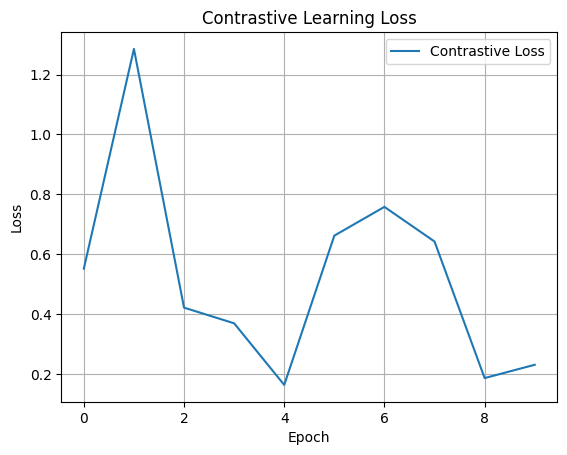

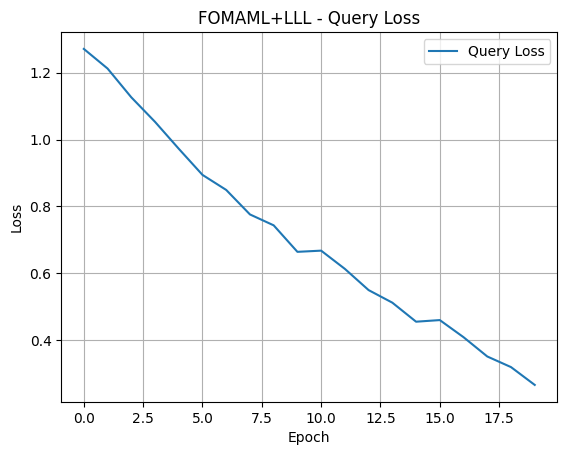

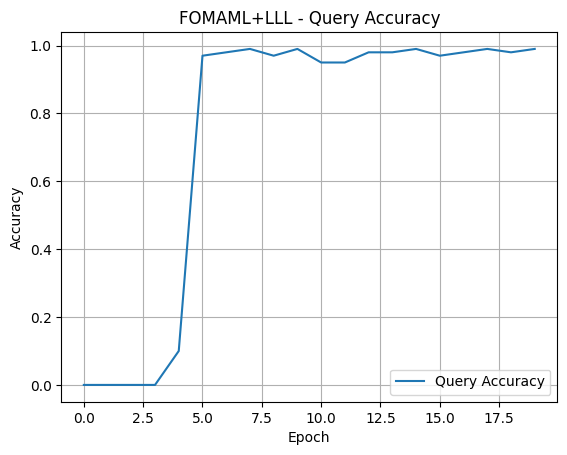

INFO:tensorflow:Assets written to: /tmp/tmppj4_d4do/assets


INFO:tensorflow:Assets written to: /tmp/tmppj4_d4do/assets
2025-08-17 13:54:33.417851: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-17 13:54:33.417916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-17 13:54:33.418801: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppj4_d4do
2025-08-17 13:54:33.423463: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-17 13:54:33.423486: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmppj4_d4do
2025-08-17 13:54:33.437103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-08-17 13:54:33.441187: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-17 13:54:33.488295: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

Saved TFLite: lstm_encoder_contrastive.tflite
INFO:tensorflow:Assets written to: /tmp/tmph_afcp7y/assets


INFO:tensorflow:Assets written to: /tmp/tmph_afcp7y/assets


Saved TFLite: meta_lstm_classifier.tflite


2025-08-17 13:54:38.054265: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-17 13:54:38.054362: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-17 13:54:38.054647: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph_afcp7y
2025-08-17 13:54:38.060840: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-17 13:54:38.060886: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmph_afcp7y
2025-08-17 13:54:38.083001: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-17 13:54:38.149435: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmph_afcp7y
2025-08-17 13:54:38.204303: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 149655 

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from collections import deque

# =============================
# 超参数
# =============================
DATA_GLOB = "./data/*.csv"
SEQ_LEN = 64
FEATURE_DIM = 64
BATCH_SIZE = 32
EPOCHS_CONTRASTIVE = 10
EPOCHS_META = 20
INNER_LR = 1e-2
META_LR = 1e-3
NUM_CLASSES = 3
NUM_TASKS = 5
SUPPORT_SIZE = 10
QUERY_SIZE = 20

np.random.seed(42)
tf.random.set_seed(42)

# =============================
# 1) 加载 CSV -> 滑窗样本
# =============================
X_labeled_list, y_labeled_list = [], []
X_unlabeled_list = []

for file in sorted(glob.glob(DATA_GLOB)):
    df = pd.read_csv(file).fillna(-1)
    data = df.values.astype(np.float32)
    feats, labels = data[:, :-1], data[:, -1]
    for i in range(len(data) - SEQ_LEN + 1):
        w_x = feats[i:i + SEQ_LEN]
        w_y = labels[i + SEQ_LEN - 1]
        if w_y == -1:
            X_unlabeled_list.append(w_x)
        else:
            X_labeled_list.append(w_x)
            y_labeled_list.append(int(w_y))

X_unlabeled = np.array(X_unlabeled_list, dtype=np.float32) if len(X_unlabeled_list) > 0 else np.empty((0,), dtype=np.float32)
if len(X_labeled_list) > 0:
    X_labeled = np.array(X_labeled_list, dtype=np.float32)
    y_labeled = np.array(y_labeled_list, dtype=np.int32)
else:
    X_labeled = np.empty((0, SEQ_LEN, X_unlabeled.shape[2] if X_unlabeled.size > 0 else 3), dtype=np.float32)
    y_labeled = np.empty((0,), dtype=np.int32)

NUM_FEATS = X_labeled.shape[2] if X_labeled.size > 0 else (X_unlabeled.shape[2] if X_unlabeled.size > 0 else 3)

# =============================
# 2) 对比学习
# =============================
def augment_window(x):
    return x + np.random.normal(0, 0.01, x.shape).astype(np.float32)

def make_contrastive_pairs(X):
    anchors, positives = [], []
    for w in X:
        anchors.append(w)
        positives.append(augment_window(w))
    return np.stack(anchors).astype(np.float32), np.stack(positives).astype(np.float32)

class NTXentLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
    def call(self, z_i, z_j):
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)
        logits = tf.matmul(z_i, z_j, transpose_b=True) / self.temperature
        labels = tf.range(tf.shape(z_i)[0])
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_j = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
        return tf.reduce_mean(loss_i + loss_j)

def build_lstm_encoder(seq_len, num_feats, feature_dim=FEATURE_DIM):
    inp = layers.Input(shape=(seq_len, num_feats))
    x = layers.LSTM(feature_dim)(inp)
    out = layers.Dense(feature_dim, activation="relu")(x)
    return models.Model(inp, out, name="lstm_encoder")

lstm_encoder = build_lstm_encoder(SEQ_LEN, NUM_FEATS, FEATURE_DIM)
contrastive_opt = tf.keras.optimizers.Adam()
ntxent = NTXentLoss(temperature=0.2)

# 若无无标签数据，生成一些随机样本以便跑通流程
if X_unlabeled.size == 0:
    X_unlabeled = np.random.randn(200, SEQ_LEN, NUM_FEATS).astype(np.float32)

anchors, positives = make_contrastive_pairs(X_unlabeled)
contrast_ds = tf.data.Dataset.from_tensor_slices((anchors, positives)).shuffle(2048).batch(BATCH_SIZE)

contrastive_loss_history = []
for ep in range(EPOCHS_CONTRASTIVE):
    for a, p in contrast_ds:
        with tf.GradientTape() as tape:
            za = lstm_encoder(a, training=True)
            zp = lstm_encoder(p, training=True)
            loss = ntxent(za, zp)
        grads = tape.gradient(loss, lstm_encoder.trainable_variables)
        contrastive_opt.apply_gradients(zip(grads, lstm_encoder.trainable_variables))
    contrastive_loss_history.append(float(loss.numpy()))
    print(f"[Contrastive] Epoch {ep+1}/{EPOCHS_CONTRASTIVE}, loss={float(loss.numpy()):.4f}")

# =============================
# 3) FOMAML 元学习 + LLL Replay
# =============================
def build_meta_model(encoder, num_classes=NUM_CLASSES):
    inp = layers.Input(shape=(SEQ_LEN, NUM_FEATS))
    x = encoder(inp)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="meta_lstm_classifier")

meta_model = build_meta_model(lstm_encoder, NUM_CLASSES)
meta_optimizer = tf.keras.optimizers.Adam(META_LR)

def sample_tasks(X, y, num_tasks=NUM_TASKS, support_size=SUPPORT_SIZE, query_size=QUERY_SIZE):
    tasks = []
    n = len(X)
    if n < support_size + query_size:
        raise ValueError(f"样本不足以构建任务：需要 {support_size+query_size}，但只有 {n}")
    for _ in range(num_tasks):
        idx = np.random.choice(n, support_size + query_size, replace=False)
        X_support, y_support = X[idx[:support_size]], y[idx[:support_size]]
        X_query, y_query = X[idx[support_size:]], y[idx[support_size:]]
        tasks.append((X_support, y_support, X_query, y_query))
    return tasks

# ---------- inner update (FOMAML / 一阶 MAML) ----------
def inner_update(model, X_support, y_support, lr_inner=INNER_LR):
    # 仅计算一阶梯度，不保留二阶
    with tf.GradientTape() as tape_inner:
        preds_support = model(X_support, training=True)
        loss_support = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(y_support, preds_support)
        )
    grads_inner = tape_inner.gradient(loss_support, model.trainable_variables)
    updated_vars = [w - lr_inner * g for w, g in zip(model.trainable_variables, grads_inner)]
    return updated_vars, float(loss_support.numpy())

# ============== LLL Replay Buffer ==============
class ReplayBuffer:
    def __init__(self, capacity=500):
        self.buffer = deque(maxlen=capacity)
    def add(self, X, y):
        for xi, yi in zip(X, y):
            self.buffer.append((xi, yi))
    def __len__(self):
        return len(self.buffer)
    def sample(self, batch_size=32):
        batch_size = min(batch_size, len(self.buffer))
        idxs = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        X, y = zip(*[self.buffer[i] for i in idxs])
        return np.array(X), np.array(y)

# 初始化 buffer
memory = ReplayBuffer(capacity=1000)

# ------------- 外环 + LLL 正则 -------------
def outer_update_with_lll(meta_model, meta_optimizer, tasks,
                          lr_inner=INNER_LR, replay_weight=0.3, replay_bs=32):
    # 累积 meta 梯度
    meta_grads = [tf.zeros_like(v) for v in meta_model.trainable_variables]
    query_acc_list, query_loss_list = [], []

    for (X_support, y_support, X_query, y_query) in tasks:
        # 备份原始权重
        orig_vars = [tf.identity(v) for v in meta_model.trainable_variables]

        # --- inner update on support ---
        updated_vars, support_loss = inner_update(meta_model, X_support, y_support, lr_inner=lr_inner)

        # 将更新后的权重写回（FOMAML：不跟踪内层更新的二阶梯度）
        for var, upd in zip(meta_model.trainable_variables, updated_vars):
            var.assign(upd)

        # --- 计算 query loss (+ LLL replay) 并对 updated_vars 求梯度 ---
        with tf.GradientTape() as tape:
            preds_q = meta_model(X_query, training=True)
            loss_q = tf.reduce_mean(
                tf.keras.losses.sparse_categorical_crossentropy(y_query, preds_q)
            )

            # LLL replay regularization（与当前 updated_vars 的输出一致性）
            if len(memory) >= 8:  # 足量才抽样
                X_old, y_old = memory.sample(batch_size=replay_bs)
                preds_old = meta_model(X_old, training=True)
                replay_loss = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_old, preds_old)
                )
                loss_total = (1.0 - replay_weight) * loss_q + replay_weight * replay_loss
            else:
                loss_total = loss_q

        grads = tape.gradient(loss_total, meta_model.trainable_variables)
        meta_grads = [mg + g / len(tasks) for mg, g in zip(meta_grads, grads)]

        # 统计 query acc/loss
        q_acc = tf.reduce_mean(
            tf.cast(tf.equal(tf.argmax(preds_q, axis=1), y_query), tf.float32)
        )
        query_acc_list.append(float(q_acc.numpy()))
        query_loss_list.append(float(loss_q.numpy()))

        # 恢复原始权重，以便处理下一任务（累积梯度仍保留）
        for var, orig in zip(meta_model.trainable_variables, orig_vars):
            var.assign(orig)

        # 更新 LLL 记忆（用原始样本即可）
        memory.add(X_support, y_support)
        memory.add(X_query, y_query)

    # 应用一次 meta 更新
    meta_optimizer.apply_gradients(zip(meta_grads, meta_model.trainable_variables))

    # 返回平均指标
    return float(np.mean(query_loss_list)), float(np.mean(query_acc_list))

# ======= 训练元学习 =======
meta_loss_history, meta_acc_history = [], []

if X_labeled.size > 0:
    for ep in range(EPOCHS_META):
        tasks = sample_tasks(X_labeled, y_labeled)
        loss, q_acc = outer_update_with_lll(meta_model, meta_optimizer, tasks)
        meta_loss_history.append(loss)
        meta_acc_history.append(q_acc)
        print(f"[Meta] Epoch {ep+1}/{EPOCHS_META}, query_loss={loss:.4f}, query_acc={q_acc:.4f}")
else:
    print("跳过元学习：没有有标签数据。")

# =============================
# 4) 绘制效果图
# =============================
plt.figure()
plt.plot(contrastive_loss_history, label="Contrastive Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Contrastive Learning Loss")
plt.legend(); plt.grid(True); plt.show()

if len(meta_loss_history) > 0:
    plt.figure()
    plt.plot(meta_loss_history, label="Query Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("FOMAML+LLL - Query Loss")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    plt.plot(meta_acc_history, label="Query Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("FOMAML+LLL - Query Accuracy")
    plt.legend(); plt.grid(True); plt.show()

# =============================
# 5) TFLite 导出
# =============================
def save_tflite(model, out_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite:", out_path)

save_tflite(lstm_encoder, "lstm_encoder_contrastive.tflite")
if X_labeled.size > 0:
    save_tflite(meta_model, "meta_lstm_classifier.tflite")


[Contrastive] Epoch 1/10, loss=0.5263
[Contrastive] Epoch 2/10, loss=1.0136
[Contrastive] Epoch 3/10, loss=0.4535
[Contrastive] Epoch 4/10, loss=0.2025
[Contrastive] Epoch 5/10, loss=0.1556
[Contrastive] Epoch 6/10, loss=0.1133
[Contrastive] Epoch 7/10, loss=0.7832
[Contrastive] Epoch 8/10, loss=0.1653
[Contrastive] Epoch 9/10, loss=0.2666
[Contrastive] Epoch 10/10, loss=0.1739
[Meta] Epoch 1/20, loss=0.7712, acc=0.9700
[Meta] Epoch 2/20, loss=0.7170, acc=0.9600
[Meta] Epoch 3/20, loss=0.6315, acc=0.9900
[Meta] Epoch 4/20, loss=0.5748, acc=1.0000
[Meta] Epoch 5/20, loss=0.5478, acc=0.9800
[Meta] Epoch 6/20, loss=0.5206, acc=0.9700
[Meta] Epoch 7/20, loss=0.4708, acc=0.9800
[Meta] Epoch 8/20, loss=0.4236, acc=0.9900
[Meta] Epoch 9/20, loss=0.3998, acc=0.9800
[Meta] Epoch 10/20, loss=0.3690, acc=0.9800
[Meta] Epoch 11/20, loss=0.3395, acc=0.9800
[Meta] Epoch 12/20, loss=0.2963, acc=0.9900
[Meta] Epoch 13/20, loss=0.3285, acc=0.9600
[Meta] Epoch 14/20, loss=0.2840, acc=0.9700
[Meta] Epoch

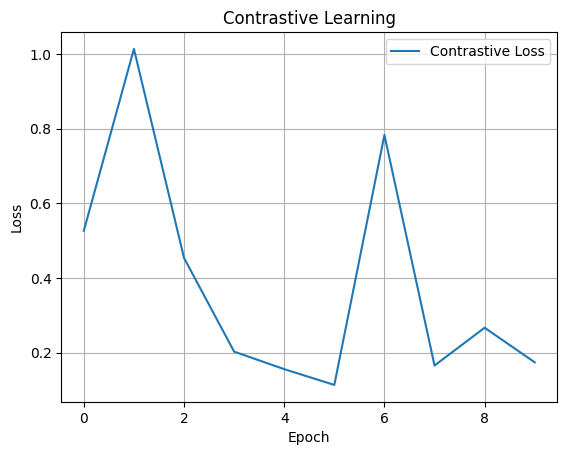

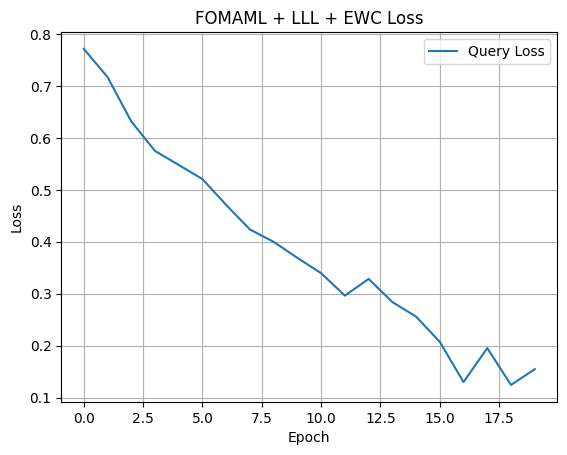

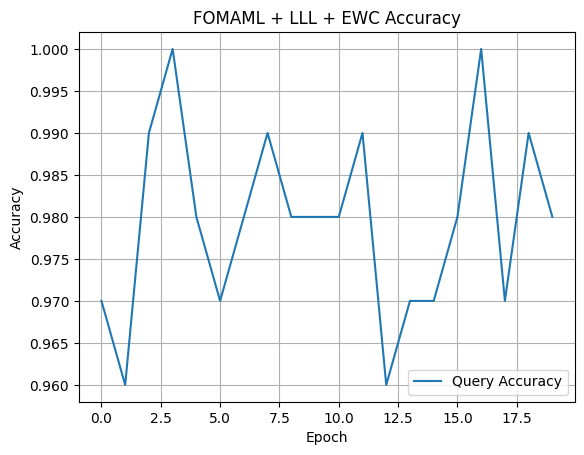

INFO:tensorflow:Assets written to: /tmp/tmp7nluvbxu/assets


INFO:tensorflow:Assets written to: /tmp/tmp7nluvbxu/assets
2025-08-17 14:11:45.435348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-17 14:11:45.435430: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-17 14:11:45.435594: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7nluvbxu
2025-08-17 14:11:45.441116: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-17 14:11:45.441139: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp7nluvbxu
2025-08-17 14:11:45.458196: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-17 14:11:45.492053: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp7nluvbxu
2025-08-17 14:11:45.514931: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

Saved TFLite: lstm_encoder_contrastive.tflite
INFO:tensorflow:Assets written to: /tmp/tmp7yh47m1c/assets


INFO:tensorflow:Assets written to: /tmp/tmp7yh47m1c/assets


Saved TFLite: meta_lstm_classifier.tflite


2025-08-17 14:11:48.412867: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-17 14:11:48.412924: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-17 14:11:48.413081: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7yh47m1c
2025-08-17 14:11:48.418542: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-17 14:11:48.418566: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp7yh47m1c
2025-08-17 14:11:48.436176: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-17 14:11:48.473040: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp7yh47m1c
2025-08-17 14:11:48.498281: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 85198 m

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from collections import deque
import random

# =============================
# 超参数
# =============================
DATA_GLOB = "./data/*.csv"
SEQ_LEN = 64
FEATURE_DIM = 64
BATCH_SIZE = 32
EPOCHS_CONTRASTIVE = 10
EPOCHS_META = 20
INNER_LR = 1e-2
META_LR = 1e-3
NUM_CLASSES = 3
NUM_TASKS = 5
SUPPORT_SIZE = 10
QUERY_SIZE = 20
REPLAY_CAPACITY = 1000
REPLAY_WEIGHT = 0.3
LAMBDA_EWC = 1e-3

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# =============================
# 1) 加载 CSV -> 滑窗样本
# =============================
X_labeled_list, y_labeled_list = [], []
X_unlabeled_list = []

for file in sorted(glob.glob(DATA_GLOB)):
    df = pd.read_csv(file).fillna(-1)
    data = df.values.astype(np.float32)
    feats, labels = data[:, :-1], data[:, -1]
    for i in range(len(data) - SEQ_LEN + 1):
        w_x = feats[i:i + SEQ_LEN]
        w_y = labels[i + SEQ_LEN - 1]
        if w_y == -1:
            X_unlabeled_list.append(w_x)
        else:
            X_labeled_list.append(w_x)
            y_labeled_list.append(int(w_y))

X_unlabeled = np.array(X_unlabeled_list, dtype=np.float32) if len(X_unlabeled_list) > 0 else np.empty((0,), dtype=np.float32)
if len(X_labeled_list) > 0:
    X_labeled = np.array(X_labeled_list, dtype=np.float32)
    y_labeled = np.array(y_labeled_list, dtype=np.int32)
else:
    X_labeled = np.empty((0, SEQ_LEN, X_unlabeled.shape[2] if X_unlabeled.size > 0 else 3), dtype=np.float32)
    y_labeled = np.empty((0,), dtype=np.int32)

NUM_FEATS = X_labeled.shape[2] if X_labeled.size > 0 else (X_unlabeled.shape[2] if X_unlabeled.size > 0 else 3)

# =============================
# 2) 对比学习
# =============================
def augment_window(x):
    return x + np.random.normal(0, 0.01, x.shape).astype(np.float32)

def make_contrastive_pairs(X):
    anchors, positives = [], []
    for w in X:
        anchors.append(w)
        positives.append(augment_window(w))
    return np.stack(anchors).astype(np.float32), np.stack(positives).astype(np.float32)

class NTXentLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
    def call(self, z_i, z_j):
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)
        logits = tf.matmul(z_i, z_j, transpose_b=True) / self.temperature
        labels = tf.range(tf.shape(z_i)[0])
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_j = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
        return tf.reduce_mean(loss_i + loss_j)

def build_lstm_encoder(seq_len, num_feats, feature_dim=FEATURE_DIM):
    inp = layers.Input(shape=(seq_len, num_feats))
    x = layers.LSTM(feature_dim)(inp)
    out = layers.Dense(feature_dim, activation="relu")(x)
    return models.Model(inp, out, name="lstm_encoder")

lstm_encoder = build_lstm_encoder(SEQ_LEN, NUM_FEATS, FEATURE_DIM)
contrastive_opt = tf.keras.optimizers.Adam()
ntxent = NTXentLoss(temperature=0.2)

if X_unlabeled.size == 0:
    X_unlabeled = np.random.randn(200, SEQ_LEN, NUM_FEATS).astype(np.float32)

anchors, positives = make_contrastive_pairs(X_unlabeled)
contrast_ds = tf.data.Dataset.from_tensor_slices((anchors, positives)).shuffle(2048).batch(BATCH_SIZE)

contrastive_loss_history = []
for ep in range(EPOCHS_CONTRASTIVE):
    for a, p in contrast_ds:
        with tf.GradientTape() as tape:
            za = lstm_encoder(a, training=True)
            zp = lstm_encoder(p, training=True)
            loss = ntxent(za, zp)
        grads = tape.gradient(loss, lstm_encoder.trainable_variables)
        contrastive_opt.apply_gradients(zip(grads, lstm_encoder.trainable_variables))
    contrastive_loss_history.append(float(loss.numpy()))
    print(f"[Contrastive] Epoch {ep+1}/{EPOCHS_CONTRASTIVE}, loss={float(loss.numpy()):.4f}")

# =============================
# 3) FOMAML + LLL + EWC
# =============================
def build_meta_model(encoder, num_classes=NUM_CLASSES):
    inp = layers.Input(shape=(SEQ_LEN, NUM_FEATS))
    x = encoder(inp)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="meta_lstm_classifier")

meta_model = build_meta_model(lstm_encoder, NUM_CLASSES)
meta_optimizer = tf.keras.optimizers.Adam(META_LR)

def sample_tasks(X, y, num_tasks=NUM_TASKS, support_size=SUPPORT_SIZE, query_size=QUERY_SIZE):
    tasks = []
    n = len(X)
    if n < support_size + query_size:
        raise ValueError(f"样本不足以构建任务：需要 {support_size+query_size}，但只有 {n}")
    for _ in range(num_tasks):
        idx = np.random.choice(n, support_size + query_size, replace=False)
        X_support, y_support = X[idx[:support_size]], y[idx[:support_size]]
        X_query, y_query = X[idx[support_size:]], y[idx[support_size:]]
        tasks.append((X_support, y_support, X_query, y_query))
    return tasks

# ---------- inner update ----------
def inner_update(model, X_support, y_support, lr_inner=INNER_LR):
    with tf.GradientTape() as tape:
        preds_support = model(X_support, training=True)
        loss_support = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(y_support, preds_support)
        )
    grads_inner = tape.gradient(loss_support, model.trainable_variables)
    updated_vars = [w - lr_inner * g for w, g in zip(model.trainable_variables, grads_inner)]
    return updated_vars

# ---------- Replay Buffer with Reservoir Sampling ----------
class ReplayBuffer:
    def __init__(self, capacity=REPLAY_CAPACITY):
        self.buffer = []
        self.capacity = capacity
        self.n_seen = 0
    def add(self, X, y):
        for xi, yi in zip(X, y):
            self.n_seen += 1
            if len(self.buffer) < self.capacity:
                self.buffer.append((xi, yi))
            else:
                # reservoir sampling
                r = np.random.randint(0, self.n_seen)
                if r < self.capacity:
                    self.buffer[r] = (xi, yi)
    def __len__(self):
        return len(self.buffer)
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self.buffer))
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        X_s, y_s = zip(*[self.buffer[i] for i in idxs])
        return np.array(X_s), np.array(y_s)

memory = ReplayBuffer(capacity=REPLAY_CAPACITY)

# ---------- outer update with LLL + EWC ----------
def outer_update_with_lll(meta_model, meta_optimizer, tasks,
                          lr_inner=INNER_LR, replay_weight=REPLAY_WEIGHT,
                          lambda_ewc=LAMBDA_EWC, prev_weights=None):
    meta_grads = [tf.zeros_like(v) for v in meta_model.trainable_variables]
    query_acc_list, query_loss_list = [], []

    for X_support, y_support, X_query, y_query in tasks:
        # 保存原始权重
        orig_vars = [tf.identity(v) for v in meta_model.trainable_variables]

        # inner update
        updated_vars = inner_update(meta_model, X_support, y_support)
        for var, upd in zip(meta_model.trainable_variables, updated_vars):
            var.assign(upd)

        # query loss + replay + EWC
        with tf.GradientTape() as tape:
            preds_q = meta_model(X_query, training=True)
            loss_q = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_query, preds_q))
            loss_total = loss_q

            # replay regularization
            if len(memory) >= 8:
                X_old, y_old = memory.sample(batch_size=32)
                preds_old = meta_model(X_old, training=True)
                replay_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_old, preds_old))
                loss_total = (1 - replay_weight) * loss_total + replay_weight * replay_loss

            # EWC regularization
            if prev_weights is not None:
                ewc_loss = 0.0
                for w, pw in zip(meta_model.trainable_variables, prev_weights):
                    ewc_loss += tf.reduce_sum(tf.square(w - pw))
                loss_total += lambda_ewc * ewc_loss

        grads = tape.gradient(loss_total, meta_model.trainable_variables)
        meta_grads = [mg + g / len(tasks) for mg, g in zip(meta_grads, grads)]

        # accuracy
        q_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds_q, axis=1), y_query), tf.float32))
        query_acc_list.append(float(q_acc.numpy()))
        query_loss_list.append(float(loss_q.numpy()))

        # 恢复原始权重
        for var, orig in zip(meta_model.trainable_variables, orig_vars):
            var.assign(orig)

        # 更新 replay buffer
        memory.add(X_support, y_support)
        memory.add(X_query, y_query)

    # meta update
    meta_optimizer.apply_gradients(zip(meta_grads, meta_model.trainable_variables))

    return float(np.mean(query_loss_list)), float(np.mean(query_acc_list)), [tf.identity(v) for v in meta_model.trainable_variables]

# ======= 训练元学习 =======
meta_loss_history, meta_acc_history = [], []
prev_weights = None

if X_labeled.size > 0:
    for ep in range(EPOCHS_META):
        tasks = sample_tasks(X_labeled, y_labeled)
        loss, acc, prev_weights = outer_update_with_lll(meta_model, meta_optimizer, tasks, prev_weights=prev_weights)
        meta_loss_history.append(loss)
        meta_acc_history.append(acc)
        print(f"[Meta] Epoch {ep+1}/{EPOCHS_META}, loss={loss:.4f}, acc={acc:.4f}")
else:
    print("跳过元学习：没有有标签数据。")

# =============================
# 4) 可视化
# =============================
plt.figure()
plt.plot(contrastive_loss_history, label="Contrastive Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Contrastive Learning")
plt.legend(); plt.grid(True); plt.show()

if meta_loss_history:
    plt.figure()
    plt.plot(meta_loss_history, label="Query Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("FOMAML + LLL + EWC Loss")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    plt.plot(meta_acc_history, label="Query Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("FOMAML + LLL + EWC Accuracy")
    plt.legend(); plt.grid(True); plt.show()

# =============================
# 5) TFLite 导出
# =============================
def save_tflite(model, out_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite:", out_path)

save_tflite(lstm_encoder, "lstm_encoder_contrastive.tflite")
if X_labeled.size > 0:
    save_tflite(meta_model, "meta_lstm_classifier.tflite")
